In [1]:
!pip install polars beautifulsoup4 splinter selenium scikit-learn matplotlib altair seaborn vl-convert-python tensorflow keras-tuner pandas pyarrow

In [2]:
#Data Manipulation and display toools
import polars as pl
from polars.exceptions import InvalidOperationError
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
# Pandas is necessary for ease of use with the ML libraries
# Polars does not use indexing and therefore does not always follow the data format properly
# Particularly the format:
#   {tablename: {index_val1: [row1_values]},
#               {index_val2: [row2_values]}}
import pandas as pd
# pyarrow necessary for polars.to_pandas() used in corr plots
import pyarrow
# Used to Display 2 dataframes next to eachother
from IPython.display import display_html 

# Web scraping tools
import re

# Data preprocessing tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version


# Machine learning tools
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, r2_score

#Necessary for tensorflow on my machine due to distutils being depreciated
import setuptools
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model, Sequential
from tensorflow.keras import optimizers
import keras_tuner as kt

random_state = 1

2024-11-26 12:41:04.383233: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 12:41:04.390702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732653664.399448   27549 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732653664.402053   27549 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 12:41:04.411250: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Overview of revisted Goals

Remove the multioutput model work

Remove the web scraping component, it does not add sufficent data for the performance loss

Remove one hot encoding of steel type. Does not add additional information over atomic composition.

1. Address multicollinearity in a way that preserves physical world explainability
   *Remove PCA or correlate with PCA dimensionality projection.
2. Implement pipelines through sklearn or tf
   * Able to intake a new row and output a hardness  
3. Implement the business case function suggested in the proposal.
   * Use a search algorythem to find conditions that predict the desired final hardness from a metal.

# Loading Data

In [3]:
cwd = pathlib.Path.cwd()

if cwd.name == 'Mild-Steel-Tempering':
    print("Path is project root")
else:
    print("Please correct current working directory to the project root")


Path is project root


In [4]:
resources_path = pathlib.PurePath(pathlib.PurePath(cwd), 'resources', 'revised')
resources_path

PurePosixPath('/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/resources/revised')

In [5]:
images_path = pathlib.PurePath(pathlib.PurePath(cwd), 'images', 'revised')
images_path

PurePosixPath('/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/images/revised')

### Many alloy composition columns were parsed incorrectly and failing to load

Several weight percent columns were parsed as int automatically due to having "0" for many initial rows. 

All weight percent columns should be parsed as float. 

In [6]:
data_path = f"{resources_path.parent}/Raiipa-tempering-data.csv"
schema_overrides = {"C (%wt)" : pl.Float64,
"Mn (%wt)" : pl.Float64,
"P (%wt)" : pl.Float64,
"S (%wt)" : pl.Float64,
"Si (%wt)" : pl.Float64,
"Ni (%wt)" : pl.Float64,
"Cr (%wt)" : pl.Float64,
"Mo (%wt)" : pl.Float64,
"V (%wt)" : pl.Float64,
"Al (%wt)" : pl.Float64,
"Cu (%wt)" : pl.Float64}

df_data = pl.read_csv(data_path, schema_overrides=schema_overrides)
df_data.glimpse()

Rows: 1466
Columns: 17
$ Source                                  <str> 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956'
$ Steel type                              <str> 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026'
$ Initial hardness (HRC) - post quenching <str> '?', '?', '?', '?', '?', '?', '?', '?', '?', '?'
$ Tempering time (s)                      <i64> 600, 600, 600, 600, 600, 600, 600, 600, 600, 600
$ Tempering temperature (ºC)              <f64> 204.4, 260.0, 315.6, 371.1, 426.7, 482.2, 537.8, 593.3, 648.9, 704.4
$ C (%wt)                                 <f64> 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25
$ Mn 

In [7]:
# save initial columns names as they are very descriptive and may be useful later
initial_column_names = df_data.columns
initial_column_names

['Source',
 'Steel type',
 'Initial hardness (HRC) - post quenching',
 'Tempering time (s)',
 'Tempering temperature (ºC)',
 'C (%wt)',
 'Mn (%wt)',
 'P (%wt)',
 'S (%wt)',
 'Si (%wt)',
 'Ni (%wt)',
 'Cr (%wt)',
 'Mo (%wt)',
 'V (%wt)',
 'Al (%wt)',
 'Cu (%wt)',
 'Final hardness (HRC) - post tempering']

# Cleaning
Many columns need renaming for ease of manipulation

Columns need datatypes correction
 'Initial hardness (HRC) - post quenching' needs datatype correction. ? is NA value


In [8]:
dict_new_cnames = {}
for og_name in initial_column_names:
    # replace filler in hardness columns
    new_name = og_name.replace(' - ', '')
    
    # Handle units
    try:
        #if alloy weight percent remove units and return only elemental symbol
        if re.search(r"\(%wt\)", og_name):
            new_name = og_name.split(' ')[0]
            #skip the rest of the try block that will re_add the units to the end
            pass
        else: 
            #If not elemental composition, lowercase the string
            new_name = new_name.lower()
        # regex find the units inside the parenthesis, of the original name, not the lowercased new name
        # This lines breaks and goes to except if there is no units
        unit = re.search(r'\((\w+)\)', og_name).group(1)
        # replace the unit parenthesis string with parenthesis with an empty string
        new_name = re.sub(r"\(.+\)", "", new_name)
        # trim to whitespace end characters left by some unit removals
        new_name = new_name.rstrip()
        # append the unit string to the end of the processed name
        new_name = f"{new_name}_{unit}"
    except:
        # skip unit processing on names with no units denoted by parenthesis
        pass

    # Strip away special characters
    new_name = new_name.encode("ascii", errors="ignore").decode()
    #replace all whitespace with underscores
    new_name = new_name.replace(' ', '_')
    #add the name to the rename dict
    dict_new_cnames[og_name] = new_name
dict_new_cnames


{'Source': 'source',
 'Steel type': 'steel_type',
 'Initial hardness (HRC) - post quenching': 'initial_hardness_post_quenching_HRC',
 'Tempering time (s)': 'tempering_time_s',
 'Tempering temperature (ºC)': 'tempering_temperature_C',
 'C (%wt)': 'C',
 'Mn (%wt)': 'Mn',
 'P (%wt)': 'P',
 'S (%wt)': 'S',
 'Si (%wt)': 'Si',
 'Ni (%wt)': 'Ni',
 'Cr (%wt)': 'Cr',
 'Mo (%wt)': 'Mo',
 'V (%wt)': 'V',
 'Al (%wt)': 'Al',
 'Cu (%wt)': 'Cu',
 'Final hardness (HRC) - post tempering': 'final_hardness_post_tempering_HRC'}

In [9]:
df_clean_cnames = df_data.rename(dict_new_cnames)

## Clean data types and column values

In [10]:
count_of_qmark = df_clean_cnames['initial_hardness_post_quenching_HRC'].value_counts()\
    .filter(pl.col('initial_hardness_post_quenching_HRC') == "?")\
        .select("count").item()


In [11]:
percent_intial_hardness_unknown = count_of_qmark / int(df_clean_cnames['initial_hardness_post_quenching_HRC'].shape[0])
print(f"Unknown initial hardness: {round(percent_intial_hardness_unknown, 2) * 100:.0f}%")


Unknown initial hardness: 65%


In [12]:
df_clean_cnames.tail(3)


source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,500.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,32.0
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,600.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,23.0
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,700.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,4.5


In [13]:
df_clean_cnames["initial_hardness_post_quenching_HRC"].value_counts().sort('count', descending=True).head(3)

initial_hardness_post_quenching_HRC,count
str,u32
"""?""",949
"""66.5""",90
"""63.1""",51


In [14]:
df_clean = df_clean_cnames.with_columns(pl.col('initial_hardness_post_quenching_HRC').cast(pl.Float64, strict=False))


In [15]:
df_clean["initial_hardness_post_quenching_HRC"].value_counts().sort('count', descending=True).head(3)

initial_hardness_post_quenching_HRC,count
f64,u32
null,949
66.5,90
63.3,51


In [16]:
df_clean.describe()

statistic,source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1466""","""1466""",517.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0
"""null_count""","""0""","""0""",949.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,61.493617,21969.754434,422.024147,0.511583,0.74073,0.017236,0.023802,0.239379,0.362838,0.389696,0.080232,0.005457,0.034379,0.005986,41.468008
"""std""",null,null,5.656383,34177.623863,176.088041,0.224354,0.252913,0.007966,0.007967,0.239193,0.810091,0.480721,0.121422,0.02905,0.20534,0.019085,14.079248
"""min""","""Grange and Baughman, 1956""","""0,31%C - plain carbon steel""",46.5,10.0,100.0,0.25,0.3,0.007,0.005,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.9
"""25%""",null,null,58.8,600.0,260.0,0.37,0.6,0.012,0.018,0.16,0.0,0.02,0.0,0.0,0.0,0.0,32.1
"""50%""",null,null,63.1,3600.0,426.7,0.42,0.74,0.017,0.024,0.21,0.01,0.06,0.0,0.0,0.0,0.0,43.1
"""75%""",null,null,66.5,14400.0,593.3,0.56,0.8,0.019,0.029,0.24,0.06,0.8,0.22,0.0,0.0,0.0,51.8
"""max""","""Penha, 2010""","""Nitriding Steel """,67.0,115200.0,704.4,1.15,1.85,0.054,0.055,1.62,3.41,1.57,0.36,0.16,1.26,0.08,68.5


# Set machine learning target

In [17]:
target_columns = ['final_hardness_post_tempering_HRC']

## Save data prior to ML preprocessing so that it may be used in the regression model 

In [18]:
#save pre-ML preprocessing data so that it can be loaded by the other file
combined_data = df_clean.clone()
combined_data.describe()


statistic,source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1466""","""1466""",517.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0
"""null_count""","""0""","""0""",949.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,61.493617,21969.754434,422.024147,0.511583,0.74073,0.017236,0.023802,0.239379,0.362838,0.389696,0.080232,0.005457,0.034379,0.005986,41.468008
"""std""",null,null,5.656383,34177.623863,176.088041,0.224354,0.252913,0.007966,0.007967,0.239193,0.810091,0.480721,0.121422,0.02905,0.20534,0.019085,14.079248
"""min""","""Grange and Baughman, 1956""","""0,31%C - plain carbon steel""",46.5,10.0,100.0,0.25,0.3,0.007,0.005,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.9
"""25%""",null,null,58.8,600.0,260.0,0.37,0.6,0.012,0.018,0.16,0.0,0.02,0.0,0.0,0.0,0.0,32.1
"""50%""",null,null,63.1,3600.0,426.7,0.42,0.74,0.017,0.024,0.21,0.01,0.06,0.0,0.0,0.0,0.0,43.1
"""75%""",null,null,66.5,14400.0,593.3,0.56,0.8,0.019,0.029,0.24,0.06,0.8,0.22,0.0,0.0,0.0,51.8
"""max""","""Penha, 2010""","""Nitriding Steel """,67.0,115200.0,704.4,1.15,1.85,0.054,0.055,1.62,3.41,1.57,0.36,0.16,1.26,0.08,68.5


In [19]:
# Al was only present in nitriding steel which was removed ealier on as additional features could not be attributed to it
combined_data.write_csv(f'{resources_path}/all_cols.csv')
combined_data.columns

['source',
 'steel_type',
 'initial_hardness_post_quenching_HRC',
 'tempering_time_s',
 'tempering_temperature_C',
 'C',
 'Mn',
 'P',
 'S',
 'Si',
 'Ni',
 'Cr',
 'Mo',
 'V',
 'Al',
 'Cu',
 'final_hardness_post_tempering_HRC']

# Checking feature correlation

There is some degree of correleation, especially negative correlations enough that a mitigation measures for multicolinearity should be taken. PCA will be done later

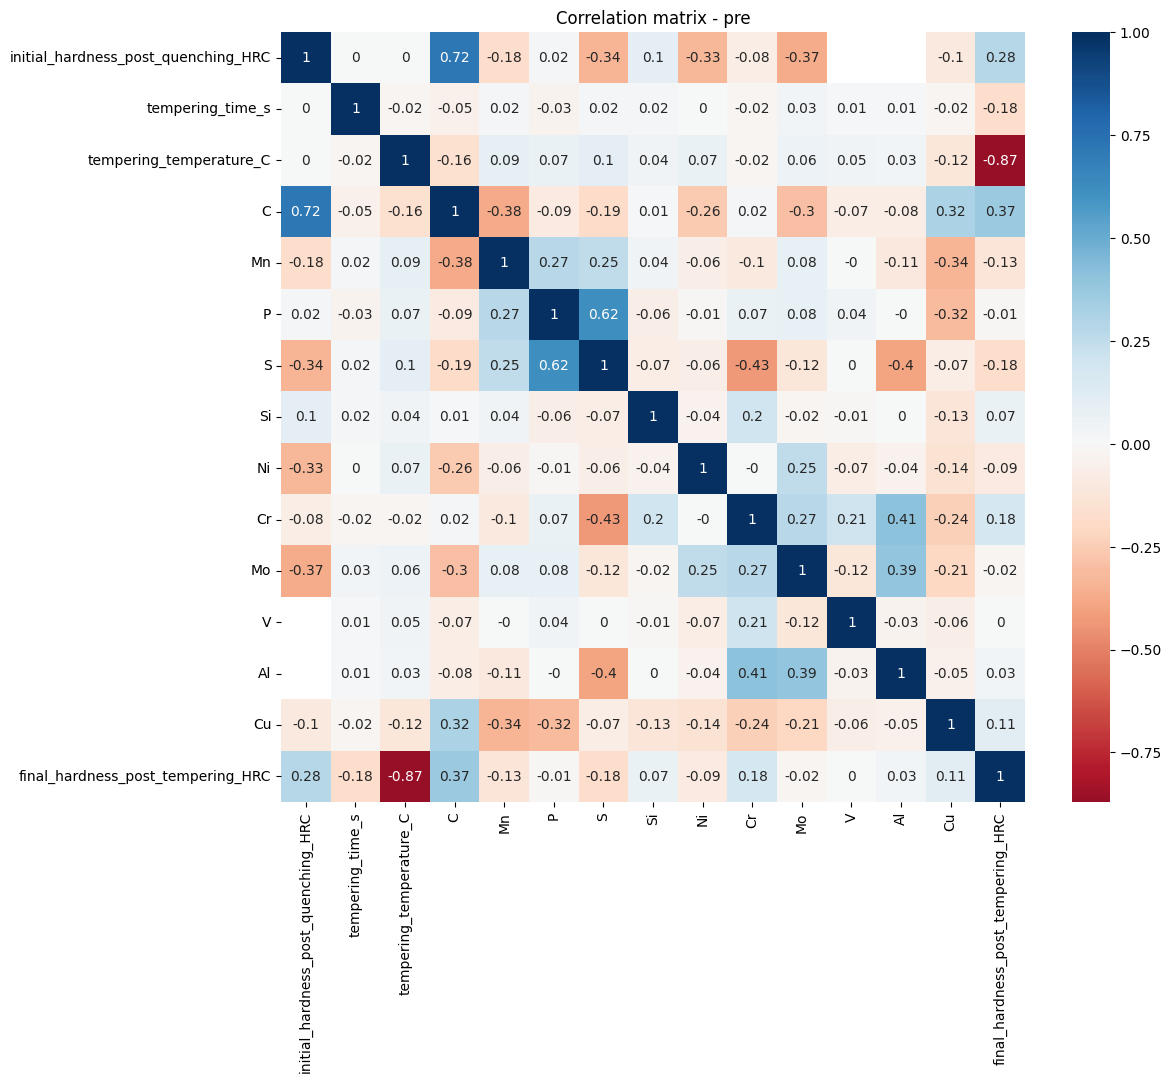

In [20]:
corr_data = pd.read_csv(f'{resources_path}/all_cols.csv')

df_corr = corr_data.corr(numeric_only=True).round(2)

plt.figure(figsize=(12, 10))
plot_corr = sns.heatmap(df_corr, annot=True, cmap='RdBu', center=0)

plt.title('Correlation matrix - pre')
plt.savefig(f'{images_path}/corr.png', bbox_inches='tight')

# Preprocess data

All columns are numeric

Soure dropped as it has no physical meaning

steel_type dropped because it encodes elemental composition as human readable

initial_hardness dropped as it has missing values for 60% of rows, and no way to sensibly predict values. Insertion of a mean or median or other factor would result in wildly incorrect synthetic data.

# Normalize variables

Almost all colums have a high degree of skew.

Will be addressed through Yeo-Johnson methods.

In [21]:
to_normalize = combined_data.drop(['source','steel_type', 'initial_hardness_post_quenching_HRC'])
to_normalize.tail(3)

tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
86400,500.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,32.0
86400,600.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,23.0
86400,700.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,4.5


In [22]:
columns = to_normalize.columns
alt.Chart(to_normalize).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
)

alt.RepeatChart(...)

In [23]:
def present_skewness_per_col(data, skew_cutoff= 1, columns= columns, output=True):
    no_skew = []
    skewed = []
    if output:
        print('column', 'skew') 
        print('-----------')
    for col in columns:
        skew = round(data[col].skew(), 2)
        if output:
            print(col, skew) 

        if np.absolute(skew) < skew_cutoff:
            no_skew.append(col)
        else:
            skewed.append(col)
    if output:
        print('count skewed:', len(skewed))
        print('count not skewed:', len(no_skew))
    else:
        return skewed

In [24]:
present_skewness_per_col(to_normalize)

column skew
-----------
tempering_time_s 1.48
tempering_temperature_C -0.06
C 1.41
Mn 2.59
P 2.27
S 0.65
Si 5.21
Ni 2.37
Cr 0.85
Mo 1.01
V 5.13
Al 5.8
Cu 2.98
final_hardness_post_tempering_HRC -0.39
count skewed: 10
count not skewed: 4


In [25]:
skewed = present_skewness_per_col(to_normalize, skew_cutoff=0.5, output=False)

In [27]:
p_ct_fix_skew = ColumnTransformer(transformers=[('yeo_johnson', PowerTransformer(), columns)],
                                  remainder= 'passthrough')

normalized = p_ct_fix_skew.fit_transform(to_normalize.to_pandas())

In [28]:
normalized_inames = pl.DataFrame(normalized)
idxnames_colnames = normalized_inames.columns
normalized = normalized_inames.rename(dict(zip(idxnames_colnames, columns)))
normalized

tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.712928,-1.247009,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,0.635692
-0.712928,-0.903298,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,0.45904
-0.712928,-0.571701,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,0.112752
-0.712928,-0.250316,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,-0.122334
-0.712928,0.063688,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,-0.352353
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.438707,-0.663678,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,0.627965
1.438707,-0.086192,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,-0.012751
1.438707,0.467466,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,-0.721352


In [29]:
def save_and_display_chart_as(chart, name):
    chart.save(f'{images_path}/{name}.png')
    return chart

In [30]:
pre_norm = alt.Chart(to_normalize).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
)

save_and_display_chart_as(pre_norm, 'pre_normalization')

alt.RepeatChart(...)

In [31]:
post_norm = alt.Chart(normalized).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
)

save_and_display_chart_as(post_norm, 'post_normalization')

alt.RepeatChart(...)

In [33]:
present_skewness_per_col(normalized)

column skew
-----------
tempering_time_s -0.08
tempering_temperature_C -0.16
C 0.19
Mn -0.19
P -0.02
S -0.05
Si -0.15
Ni 1.45
Cr 0.46
Mo 0.84
V 5.13
Al 5.8
Cu 2.82
final_hardness_post_tempering_HRC -0.16
count skewed: 4
count not skewed: 10


## Normalization successful

Down from 10 with high skew to 4 out of 14 columns

Viewing the 4 columns that retained high skew, the data is essentially binary, on a continuos scale

## Scale numerical columns 

All columns are numeric and range from 0.0# to 1000 so scaling is necessary

This will ensure the small elemental composition values are not overshadowed by the large strength properties 

y is not scaled as it is normalized and a single target column

In [34]:
to_scale = normalized.clone()

In [35]:
to_scale_X = to_scale.drop(target_columns)
y = to_scale.select(target_columns)

In [36]:
def get_scaler_rename_dict(data_scaler):
    scaler_names = data_scaler.get_feature_names_out()
    columns = [f'column_{n}' for n in range(len(scaler_names))]
    rename_dict = dict(zip(columns, scaler_names))
    return rename_dict

def std_scale_data(to_scale):
    scaler = StandardScaler()
    d_scaled = scaler.fit_transform(to_scale)
    rename_dict = get_scaler_rename_dict(scaler)
    return (pl.DataFrame(d_scaled).rename(rename_dict), scaler)
    

In [37]:
df_scaled_X, scaler_X = std_scale_data(to_scale_X)
df_scaled_X.tail(3)


tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.438707,0.467466,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477
1.438707,1.002838,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477
1.438707,1.523461,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477


In [38]:
columns = df_scaled_X.columns
post_scale_x = alt.Chart(df_scaled_X).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
)

save_and_display_chart_as(post_scale_x, 'X_post_scaling')

alt.RepeatChart(...)

In [39]:
df_scaled_X.write_csv(f"{resources_path}/df_X.csv")
y.write_csv(f"{resources_path}/df_y.csv")

# Modelling

In [40]:
X = pl.read_csv(f'{resources_path}/df_X.csv')
y = pl.read_csv(f'{resources_path}/df_y.csv',   
                schema={'final_hardness_post_tempering_HRC': pl.Float32})

# Polars does not always work well with Keras
X = X.to_pandas()
y = y.to_pandas()
print(y)
X.head(3)

      final_hardness_post_tempering_HRC
0                              0.635692
1                              0.459040
2                              0.112752
3                             -0.122334
4                             -0.352353
...                                 ...
1461                           0.627965
1462                          -0.012751
1463                          -0.721352
1464                          -1.309197
1465                          -2.298563

[1466 rows x 1 columns]


,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu
0,-0.712928,-1.247009,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477
1,-0.712928,-0.903298,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477
2,-0.712928,-0.571701,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477


## Test train split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=random_state)

# Single target Regression

Target final hardness, include tempering process as data

## Gradient boost regression

The final hardness is a continuos varaible, that may be non-linear with respect to the supporting features. 

### This model does perform well, r<sup>2</sup> = 0.98

I will attmpt to use neural network modelling to see if it can be improved, and to get history.


In [42]:
gb_regressor = GradientBoostingRegressor(random_state=random_state)

gb_regressor.fit(X_train, y_train)


/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=1)

In [43]:
y_pred = gb_regressor.predict(X_test)
y_pred.shape

(367,)

In [44]:
# match y_test shape to model output shape
def reshape_y_to_1d(y_test):
    return y_test.reshape(1,-1)[0]

In [45]:
print("R2 score:", round(gb_regressor.score(X_test, y_test), 5))

R2 score: 0.9815


In [46]:
test_df = pl.DataFrame({'Real Final Hardness (HRC)' : y_test['final_hardness_post_tempering_HRC'],
                        'Predicted Final Hardness (HRC)' : y_pred})
test_df.head(3)

Real Final Hardness (HRC),Predicted Final Hardness (HRC)
f32,f64
0.566297,0.53217
-0.542271,-0.391434
1.075021,1.125768


## Evaluation of GBR with scale and normalization.

In [47]:
base = alt.Chart(test_df).mark_point().encode(
    alt.X('Real Final Hardness (HRC)'),
    alt.Y('Predicted Final Hardness (HRC)')
)

fit = base.transform_regression(
    'Real Final Hardness (HRC)','Predicted Final Hardness (HRC)', method='linear'
).mark_line(color='red').encode()

plot_gbr_fit = (base + fit).properties(title='GBRegression Fit')

save_and_display_chart_as(plot_gbr_fit, 'GBR_fit')

alt.LayerChart(...)

In [48]:
df_scaled_X.columns

['tempering_time_s',
 'tempering_temperature_C',
 'C',
 'Mn',
 'P',
 'S',
 'Si',
 'Ni',
 'Cr',
 'Mo',
 'V',
 'Al',
 'Cu']

In [49]:
gb_regressor.feature_names_in_

array(['tempering_time_s', 'tempering_temperature_C', 'C', 'Mn', 'P', 'S',
       'Si', 'Ni', 'Cr', 'Mo', 'V', 'Al', 'Cu'], dtype=object)

/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


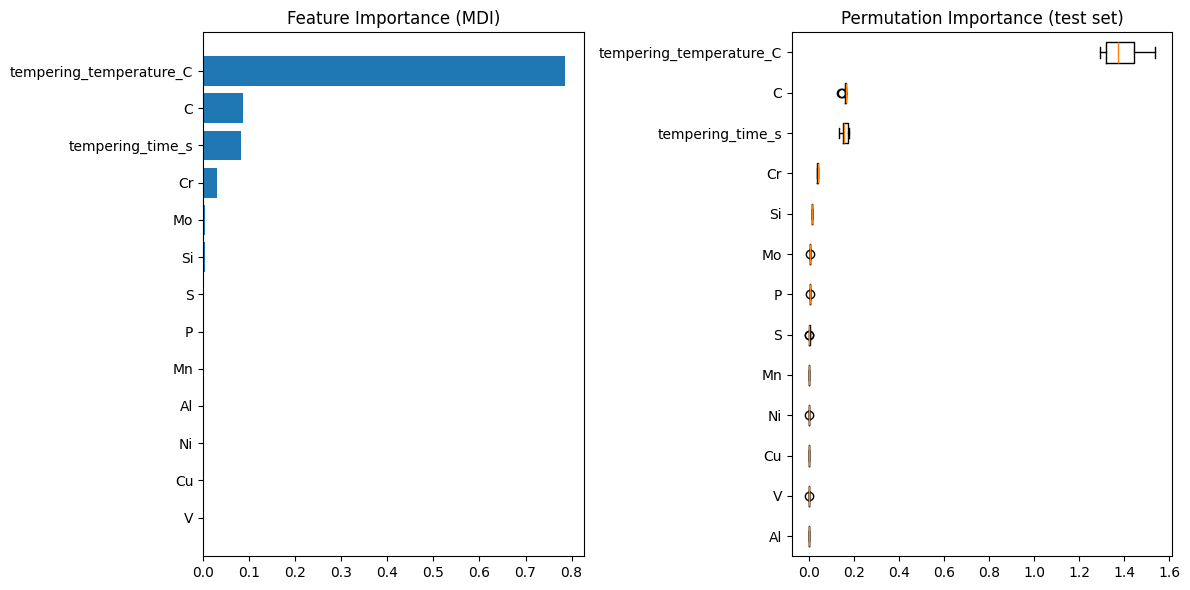

In [50]:
# Adpated from 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

feature_importance = gb_regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5

plot_feature_importance, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_yticks(pos, np.array(gb_regressor.feature_names_in_)[sorted_idx])
ax1.barh(pos, feature_importance[sorted_idx], align="center")
ax1.set_title("Feature Importance (MDI)")

result = permutation_importance(
    gb_regressor, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

tick_labels_dict = {
    'tick_labels': np.array(gb_regressor.feature_names_in_)[sorted_idx]
}

ax2.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
ax2.set_title("Permutation Importance (test set)")
plot_feature_importance.tight_layout()
plot_feature_importance.savefig(f'{images_path}/GBR_feature_importance.png')

## Gradient boost regression as a good fit

R2 score is 0.92 without scaling. This is quite good.

R2 score is 0.93 with y-scaling. Marginally better.

Moving to a Deep Neural Network model to try and improve performance.

The predicted vs actual plot do not appear to have a different shape than the model results


# Surprising result, Cu

I was unaware copper has a major effect on tempering results, as can be seen in literature [here](https://www.sciencedirect.com/science/article/abs/pii/S0261306914004361), [here](https://link.springer.com/article/10.1007/s11015-022-01285-3) and [here](https://www.ispatguru.com/copper-in-steels/).

This is a surprising result for me, as I am not a metallurgist.

Revisting this it can be seen that pre- and post- normalization do not align properly. Normalization was being applied only to 'skewed' distributions, of which copper was one. As seem in the image, the extremety and discontinuity of the skew should not have resulted in such a clean normalization result. The expected result can be seen in other columns like Mo and V. Passing all columns through the normalization process appears to have fixed this error.

![image](images/revised/Cu_norm_bug.png)

In [51]:
target_columns[0]

'final_hardness_post_tempering_HRC'

In [52]:
def build_df_GBR(data, target=target_columns, model=GradientBoostingRegressor,   random_state=random_state):
    # to_pandas() from polars df silences a lot of warnings
    #split X and y into seperate dataframes
    X = data.drop(target).to_pandas()
    y = data.select(target).to_pandas()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        random_state=random_state)
    # generate train_test_split list of dataframes to return for other functions
    tts_df = [X_train, X_test, y_train, y_test]
    #Build model
    gb_regressor = model(random_state=random_state)
    gb_regressor.fit(X_train, 
                     y_train)
    # Predict and evaluate
    y_pred = gb_regressor.predict(X_test)
    print("R2 score:", round(gb_regressor.score(X_test, y_test), 5))
    eval_df = pl.DataFrame({'Real Final Hardness (HRC)' : y_test[target[0]],
                            'Predicted Final Hardness (HRC)' : y_pred})
    #return y{_test, _predict} df, model, and training+test dataframes list
    return eval_df, gb_regressor, tts_df

def plot_regression_fit(eval_df):
    # plot the test and predict columns against eachother
    base = alt.Chart(eval_df).mark_point().encode(
        alt.X('Real Final Hardness (HRC)'),
        alt.Y('Predicted Final Hardness (HRC)')
        )
    # caluclate a linear regression between them
    fit = base.transform_regression(
        'Real Final Hardness (HRC)',
        'Predicted Final Hardness (HRC)', 
        method='linear'
        ).mark_line(color='red').encode()
    # Overlay  the 2 plots
    plot_gbr_fit = (base + fit).properties(title='GBRegression Fit')
    return plot_gbr_fit

def plot_feature_importance(model, tts_df, random_state=random_state):
    # generate 2 chart plot
    plot_importances, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    #plot feature importance
    # get feature importantace for the model
    feature_importance = model.feature_importances_
    # list of indicies sorted by largest to smallest feature importance
    sorted_idx = np.argsort(feature_importance)
    # generate offset bar positions so they are centered on tick marks
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    # set y-ticks as feature names sorted by feature importance
    ax1.set_yticks(pos, np.array(model.feature_names_in_)[sorted_idx])
    # set bar sizes and positions sorted by feature importance
    ax1.barh(pos, feature_importance[sorted_idx], align="center")
    ax1.set_title("Feature Importance (MDI)")

    # plot permutation importance
    X_test, y_test = tts_df[1], tts_df[3]
    # calculate permutation importance, if noise is added to this columns, does it matter 
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=random_state
    )
    # generate a NEW list of indicies sorted by largest to smallest permutation importance
    sorted_idx = result.importances_mean.argsort()
    tick_labels_dict = {
        # set permutation feature names using the new sorted list of permutation importance indeicies 
        'tick_labels': np.array(model.feature_names_in_)[sorted_idx]
    }
    # plot permutation importance
    ax2.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
    ax2.set_title("Permutation Importance (test set)")

    # tight layout prevents axis titles from running into other plot areas.
    plot_importances.tight_layout()
    return plot_importances
    

R2 score: 0.98038


/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


alt.LayerChart(...)

/tmp/ipykernel_27549/415925315.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_feature_importance(nopreproc_model, nopreproc_tts_df).show()


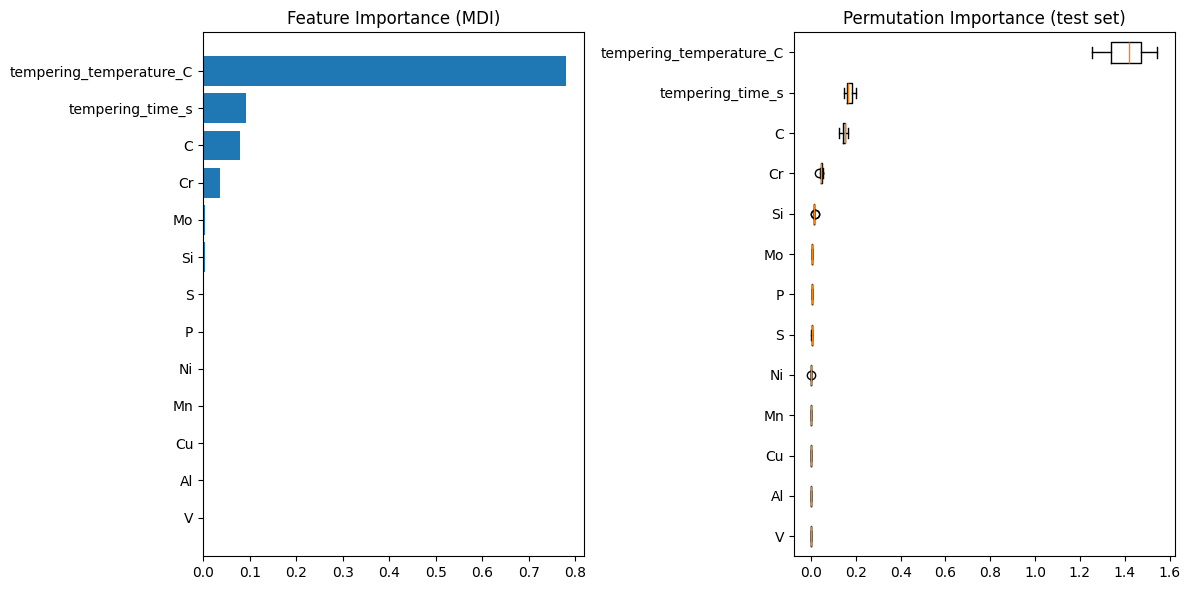

In [53]:
nopreproc_eval_df, nopreproc_model, nopreproc_tts_df = build_df_GBR(to_normalize)
plot_regression_fit(nopreproc_eval_df).show()
plot_feature_importance(nopreproc_model, nopreproc_tts_df).show()

R2 score: 0.9815


/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


alt.LayerChart(...)

/tmp/ipykernel_27549/613344124.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_feature_importance(nopreproc_model, nopreproc_tts_df).show()


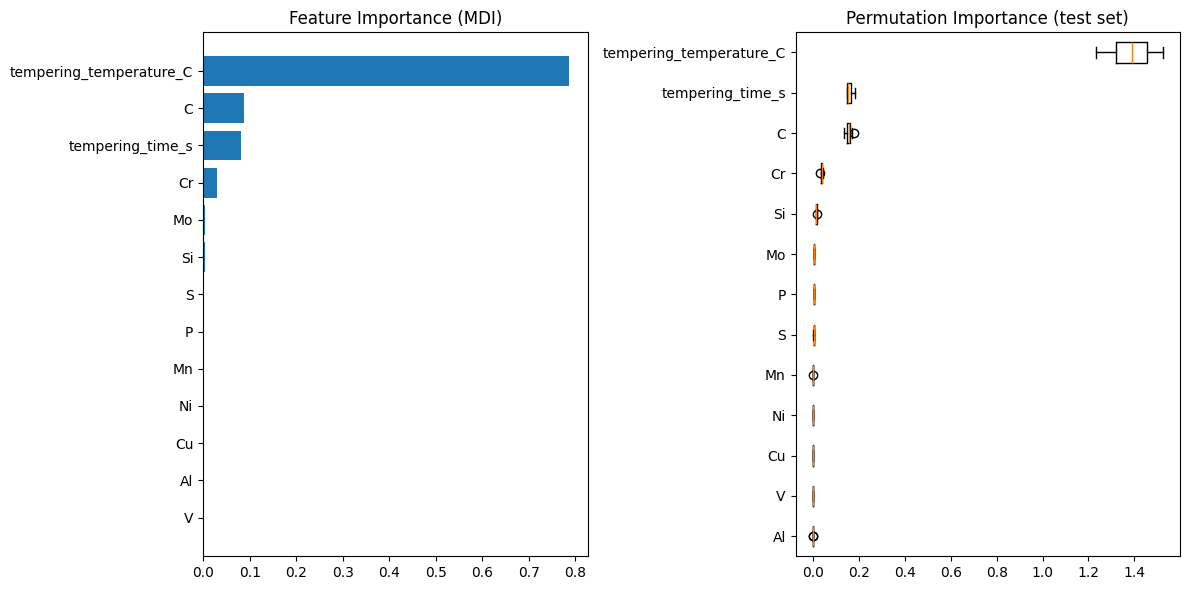

In [54]:
nopreproc_eval_df, nopreproc_model, nopreproc_tts_df = build_df_GBR(normalized)
plot_regression_fit(nopreproc_eval_df).show()
plot_feature_importance(nopreproc_model, nopreproc_tts_df).show()

# Building a pipeline

Pipeline psuedocode

pipe = [skew adj, normalize, scale]

In [55]:
p_skew_fix = ColumnTransformer(transformers=[('yeo_johnson', PowerTransformer, skewed)],
                               remainder= 'passthrough')
pipe_gbr = Pipeline(steps = [('fix_skew', p_skew_fix),
                         ('std_scaler', StandardScaler()),
                         ('gb_regressor', GradientBoostingRegressor())])